# Web Search 2018 - Tutorial 5: Multi-Feature Label Propagation
## Contents

1. [Overview](#head1)
  1. [Code Imports](#head11)
2. [Iterative Label Propagation on Web Data](#head2)
  1. [Multi-label LP Algorithm](#head21)
  2. [Implement the Multi-label LP Algorithm](#head22)
  3. [Evaluation](#head23)
  4. [Exercises](#head24)
3. [Multi-Feature Iterative Label Propagation](#head3)
  1. [Implement the Multi-Feature Iterative Label Propagation](#head31)
  2. [Exercises](#head32)

## <a name="head1"></a> Overview

In the previous lab you implemented the Iterative Label Propagation algorithm, which consists of a semi-supervised graph approach to annotate uncategorized/unlabelled data starting from a small set of categorized/labelled data.

The target dataset was the MNIST Digits, which is only adequate for implementation purposes (i.e. testing, debugging, etc.). In this lab, the first step will be to apply the LP algorithm to Web data and analyse its behaviour.


Additionally, in the LP implementation of the previous lab, semantic affinity between documents (images/texts) was computed based on a **single feature space**. In this lab the LP algorithm definition will be revisited in order to accomodate the computation of semantic affinity between documents under **multiple feature spaces**. This will allow the construction of a much more richer graph, supporting propagation of labels by different similarity criteria. 


**Lab objectives:**
* Apply the iterative version of the Label Propagation algorithm to Web data scenario and analyse the results;
* Implement the Multi-feature iterative Label Propagation algorithm.

### <a name="head11"></a> Code Imports

In [1]:
from tokenizer import tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import pandas as pd
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.io import imread
from sklearn.preprocessing import normalize
from skimage import color
from skimage import data, exposure
import random
from numpy.random import shuffle
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from skimage import img_as_ubyte
import warnings
import os
import time
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
warnings.filterwarnings('ignore')

print(os.getcwd(), "changing to:", os.getcwd()+"/../")

# Change this according to the path where you have the ws_toolkit
ws_toolkit_path = os.getcwd()+"/.."

os.chdir(ws_toolkit_path)
print(os.getcwd())
from ws_toolkit.utils import center_crop_image, k_neighbours, hoc, init_bow, process_images_keras

Using TensorFlow backend.


/Users/franciscorodrigues/Projects/PW/pw_phase2/labs changing to: /Users/franciscorodrigues/Projects/PW/pw_phase2/labs/../
/Users/franciscorodrigues/Projects/PW/pw_phase2
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/franciscorodrigues/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Global Variables

In [2]:
# Cached arrays
colorMatrix = None
gradientMatrix = None
croppedImages = []
dataSetPredictions = []


### Pre Processing

In [3]:
def cropImageList(images):
    global croppedImages
    if len(croppedImages) <= 0:
        for imgName in images:
            croppedImg = []
            # Read image
            img = imread("./images/"+imgName)
            # Resize image
            croppedImg = center_crop_image(img, size=224)
            croppedImages.append(croppedImg)
    else:
        print("Using cached cropped images")
    return croppedImages

# Read dataset .csv
df = pd.read_csv("./visualstories_edfest_2016_twitter_xmedia.csv",
                 sep=';', encoding="utf-8")

data = np.array([df.get("text").values, df.get(
    "image-url").values, df.get("gt_class").values])
# This are the text of the tweets
tweets = data[0]
# This are the links of the images of the tweets (ex: C0zsADasd213.jpg)
imageLinks = [i.replace('https://pbs.twimg.com/media/', '') for i in data[1]]
# This are the arrays of the data of each cropped image
targets = [list(map(int, c.replace(' ', '').split(","))) for c in data[2]]
# Save cropped images in cache
croppedImages = cropImageList(imageLinks)

### Feature Spaces

In [4]:
def features_hog(images, pixels_per_cell=(32, 32), orientations=8):
    global gradientMatrix
    if gradientMatrix is None:
        gradientMatrix = []
        for img in images:
            # Convert to grayscale
            img_gray = rgb2gray(img)   
            # Extract HoG features
            hist = hog(img_gray, orientations=orientations, pixels_per_cell=pixels_per_cell)   
            # Normalize features
            # We add 1 dimension to comply with scikit-learn API
            hist = np.squeeze(normalize(hist.reshape(1, -1), norm="l2"))  
            gradientMatrix.append(hist)
        # Creating a feature matrix for all images
        gradientMatrix = np.array(gradientMatrix)
    return gradientMatrix

def getColorMatrix(_croppedImages, _bins=(4,4,4), _hsv=True): 
    global colorMatrix
    #Histogram of colors results
    if colorMatrix is None:   
        colorMatrix = []
        for img in _croppedImages:    
            # Change image color space from RGB to HSV. 
            # HSV color space was designed to more closely align with the way human vision perceive color-making attributes
            img_q = img
            if _hsv:
                img_q = color.rgb2hsv(img)    
            # convert image pixels to [0, 255] range, and to uint8 type
            img_q = img_as_ubyte(img_q)
            # Extract HoC features
            hist, bin_edges = hoc(img_q, bins=_bins)    
            # Normalize features
            # We add 1 dimension to comply with scikit-learn API
            hist = np.squeeze(normalize(hist.reshape(1, -1), norm="l2"))    
            colorMatrix.append(hist)    
        # Creating a feature matrix for all images
        colorMatrix = np.array(colorMatrix)
    return colorMatrix

def execute_bow(_dataTexts, _lemmatize=False, _mdf=3, _metric="cosine", _k=10, _handles=False, _hashes=False, _case=False, _url=False):
    tknzr = tokenizer.TweetTokenizer(preserve_handles=_handles, preserve_hashes=_hashes, preserve_case=_case, preserve_url=_url)
    vectorizer, texts_bow = init_bow(_dataTexts, {"tknzr": tknzr, "lemmatize": _lemmatize}, _mdf)
    return texts_bow

def getTagsBow(_dataImages):
    global dataSetPredictions
    model = VGG16(weights='imagenet', include_top=True)
    start = time.time()
    if len(dataSetPredictions) <= 0:
        start_i = time.time()
        img_list = process_images_keras(_dataImages)
        end_i = time.time()
        print("Processed Images finished: {}".format(end_i - start_i))
        #model = ResNet50(weights='imagenet')
        # Convert from list to ndarray
        img_array_list = np.vstack(img_list)
        # Feed all images to the model
        print("No Cached Predictions")
        dataSetPredictions = model.predict(img_array_list)
    else:
        print("Using Cached Predictions")
    end = time.time()
    print("Model Predictions finished: {}".format(end - start))
    #print("Resulting shape of the network output: {}".format(preds.shape))
    concepts = decode_predictions(dataSetPredictions, top=5)
    # Experiment with this parameter
    k = 5
    # Get the top K most probable concepts per image
    sorted_concepts =  np.argsort(dataSetPredictions, axis=1)[:,::-1][:,:k]
    data_tags = concepts
    mlb = MultiLabelBinarizer(classes=range(0,1000))
    tags_bow = mlb.fit_transform(sorted_concepts)
    #print(tags_bow.shape)
    return tags_bow

# <a name="head2"></a> Iterative Label Propagation on Web Data

Consider a dataset $X=\{x_1, x_2, \ldots, x_L, \ \ x_{L+1}, \ldots, x_N\}$, with $N$ data points, where each $x_i$ consists of some feature representation of document $i$. Given a categories set $C=\{1, 2, \ldots, |C|\}$, it is assumed that the first $L$ data points are labelled with a label $c \in C$, and the remaining ones are unlabelled.

Please refer to the "Mining Data Graphs" class (lectured on 29/10), namely slides 28, 29 and 30, for a description of the algorithm steps.

For more information, you can check the original paper: Dengyong Zhou, Olivier Bousquet, Thomas Navin Lal, Jason Weston, Bernhard Schoelkopf. Learning with local and global consistency (2004) http://citeseer.ist.psu.edu/viewdoc/summary?doi=10.1.1.115.3219


## <a name="head21"></a> Multi-label LP Algorithm

Apply the Iterative LP algorithm on your project dataset and discuss its effectiveness.

The dataset has a total of 13 categories. The categories of each document are available in the corresponding line of that document (column 'gt_class'), in the provided .csv file. Multiple categories are separated by a comma ','. You should represent each document's categories as a 13-dimensional vector (one-hot encoding), as you did for the MNIST dataset. In this case, you may have more than 1 active dimension.

### <a name="head22"></a> Implement the Multi-label LP Algorithm

**Multi-label LP:** As each document has multiple categories, you will need to modify your LP implementation. Instead of an **argmax** to select the final category of each document, you will need to **select the top-k categories**, by applying a threshold on the number of categories assigned.

**Discuss:** Discuss examples of thresholds (e.g. select the top-3 labels, keep all categories with their values $>\alpha$, etc.)  .


In [32]:
def runAlg(mlb, images, y, y_true, feature, threshold, alpha, iterations, params=None, mf = False, indices_unlabeled=[]):
   
    # Step 1 - Extract features for each image (HoG/CNN/HoC) in X
    pixels_per_cell = (32, 32)
    orientations = 8
    
    bins = (4,4,4)
    hsv = True
    
    _lemmatize=False
    _mdf=3
    _metric="cosine"
    _k=10
    _handles=False
    _hashes=False
    _case=False
    _url=False
    
    if mf is True:
        X1 = features_hog(images, pixels_per_cell, orientations)
        X2 = getColorMatrix(images, bins, hsv)
        X3 = execute_bow(tweets, _lemmatize, _mdf, _metric, _k, _handles, _hashes, _case, _url)
        X4 = getTagsBow(imageLinks)
    else:
        if feature is "hog":
            X = features_hog(images, pixels_per_cell, orientations)
        elif feature is "hoc":
            X = getColorMatrix(images, bins, hsv)
        elif feature is "bow":
            X = execute_bow(tweets, _lemmatize, _mdf, _metric, _k, _handles, _hashes, _case, _url)
        else:
            X = getTagsBow(imageLinks)

    # Step 2 - Normalize Y and Initialize matrix F with Y
    Y_hidden = normalize(y, axis = 1, norm="l1")
    F = Y_hidden
    #print(F[indices_labeled[0],:])
    
    # Step 3 - Compute matrix W (multi feature -mf true; or single feature -mf false)
    W = []
    if mf is True:
        M = 0.1*euclidean_distances(X1, X1)+ 0.1*euclidean_distances(X2, X2) + 0.3*euclidean_distances(X3, X3) + 0.5*euclidean_distances(X4, X4)
        sigma = np.std(M)
        W = np.exp(-1 * M / (2*sigma**2))
    else:
        M = euclidean_distances(X, X)
        sigma = np.std(M)
        W = np.exp(-1 * M / (2*sigma**2))

    # Step 4 - Normalize W
    D = np.zeros(W.shape)
    np.fill_diagonal(D, W.sum(axis=0))

    D12 = np.zeros(D.shape)
    from numpy.linalg import inv
    D12 = inv(np.sqrt(D))

    S = np.dot(D12, W)
    S = np.dot(S, D12)

    # Step 5 - Perform the F update step num_iterations steps
    for i in range(1, iterations):
        T1 = alpha * S
        T1 = np.dot(T1, F)
        T2 =  (1 - alpha) * Y_hidden
        F = T1 + T2
        #Normalizar para F (verficar segmentos)
        F = normalize(F, axis = 1, norm="l1")
        
    print("Indice unlabeled: {}\nNormalized F: {}".format(indices_unlabeled[0], F[indices_unlabeled[0],:]))
    # Select top k classes
    #F = np.fliplr(np.argsort(F, axis=1))
    # Get the top 5 only classes
    #F = F[:,:3]
    T = []
    for row in F:
        T.append([i for i, v in enumerate(row) if v >= threshold])
    Y = mlb.transform(T)
    return Y

In [33]:
def runAll(iterations):
    #Choose a random number between 1 and 100 to shuffle to prevent biased results
    rand_seed = random.randint(1,100)
    indices = np.arange(len(tweets))
    np.random.seed(rand_seed)
    shuffle(indices)

    X = tweets
    np.random.seed(rand_seed)
    shuffle(X)

    y_target = targets
    np.random.seed(rand_seed)
    shuffle(y_target)

    total_images = X.shape[0]

    # Let's assume that 20% of the dataset is labeled
    labeled_set_size = int(total_images*0.2)

    indices_labeled = indices[:labeled_set_size]
    indices_unlabeled = indices[labeled_set_size:]
    
    print(" ")
    print("Iteration: {} - Total tweets labeled: {} - Total tweets unlabeled: {}".format(iterations,
        len(indices_labeled), len(indices_unlabeled)))


    # Convert labels to a one-hot-encoded vector
    # Keep groundtruth labels
    classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    # print(classes)
    mlb = MultiLabelBinarizer(classes=classes)
    #print(y_target[:1])
    Y_true = mlb.fit_transform(y_target)
    Y = mlb.transform(y_target)
    #print(Y[:1])
    # Remove labels of "unlabeled" data 
    Y[indices_unlabeled, :] = np.zeros(Y.shape[1])
    
    # Run Algorithm and Get Results
    feature = "hog"
    alpha = 0.8
    mf = False
    Y = runAlg(mlb, croppedImages, Y, Y_true, feature=feature, threshold=0.05,
            alpha=alpha, iterations=iterations, mf=mf, indices_unlabeled=indices_unlabeled)

    Y_pred = Y[indices_unlabeled, :]
    y_gt = Y_true[indices_unlabeled, :]
   
    
    print("Ground Truth: {}".format(Y_true[indices_unlabeled[0],:]))
    print("Predicted:    {}".format(Y[indices_unlabeled[0],:]))
    
   
    return Y_pred, y_gt

### <a name="head23"></a>  Evaluation
Evaluate the results of each run of the Iterative LP.

 
Iteration: 10 - Total tweets labeled: 400 - Total tweets unlabeled: 1600
Indice unlabeled: 1528
Normalized F: [0.01818135 0.00260966 0.02267159 0.00166583 0.00726905 0.01895788
 0.08486458 0.03613609 0.38647321 0.01651218 0.02578738 0.00338952
 0.37548169]
Ground Truth: [0 0 0 0 0 0 1 0 0 0 0 0 0]
Predicted:    [0 0 0 0 0 0 1 0 1 0 0 0 1]
 
Iteration: 60 - Total tweets labeled: 400 - Total tweets unlabeled: 1600
Indice unlabeled: 689
Normalized F: [0.15174137 0.04217874 0.04980129 0.02039158 0.02374887 0.11568819
 0.14418644 0.00598495 0.10268911 0.12394465 0.06247353 0.03237119
 0.12480009]
Ground Truth: [0 0 0 0 0 0 0 1 1 0 0 0 0]
Predicted:    [1 0 0 0 0 1 1 0 1 1 1 0 1]
 
Iteration: 110 - Total tweets labeled: 400 - Total tweets unlabeled: 1600
Indice unlabeled: 499
Normalized F: [0.13796468 0.00922595 0.05326146 0.01122805 0.02552418 0.01223272
 0.21676272 0.00559201 0.08168234 0.03644428 0.16762005 0.08604238
 0.15641918]
Ground Truth: [0 0 0 0 0 0 0 1 1 0 0 0 1]
Predicted:    

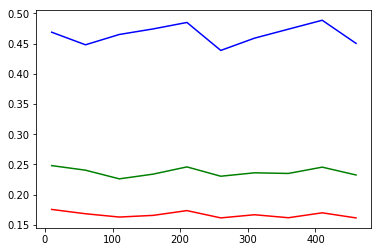

In [37]:
from sklearn.metrics import precision_recall_fscore_support as score

results = np.zeros((10,4))
range_iterations = range(10,500,50)
j = 0

for i in range_iterations:
    Y_pred, y_gt = runAll(i)
    precision, recall, fscore, support = score(y_gt, Y_pred, average='macro')
    results[j] = [precision, recall, fscore, support]
    j = j+1

from sklearn.metrics import classification_report
np.set_printoptions(threshold=np.nan)

print("\nResults List:    \n{}".format(results))
print("\nResults Report:  \n{}".format(classification_report(y_gt, Y_pred)))

print("\nResults Graph:   \n")
# %%
import matplotlib.pyplot as plt
plt.plot(range_iterations, results[:,0], 'r', range_iterations, results[:,1], 'b', range_iterations, results[:,2], 'g')

### <a name="head24"></a>  Exercises

In [ ]:
# Which feature spaces are more effective? Do a per-class inspection and understand which feature spaces are more effective for each class and why. 

# How does the LP algorithm behaves when you change the number of initial labels? (variable labeled_set_size on lab4)

# Note that documents (Tweets) from your project's dataset have multiple labels, i.e. each document may belong to 1 or more classes. 
# Discuss how this impacts the label propagation. 

# <a name="head3"></a> Multi-Feature Iterative Label Propagation 

Recall the computation of the affinity matrix S.

Given some feature space representation, each entry $w_{ij}$, for $i\neq j$ is computed as:

$$
\begin{align}
w_{ij} = exp\Big({-\frac{||x_i - x_j||^2}{2\sigma^2}}\Big),
\end{align}
$$
where a Gaussian kernel is applied over the distance on the considered feature space.


In order compute affinity by considering **multiple feature spaces**, the above expression can be extended as:

$$
\begin{align}
w_{ij} = exp\Big({-\frac{\Big[\sum_{f}\alpha_f\cdot||x_i^f - x_j^f||\Big]^2}{2\sigma^2}}\Big),
\end{align}
$$
where each $x^f$ denotes a given feature space and $\alpha_f$ the weight associated with that space. The weights should be defined such that $\sum_f \alpha_f = 1$.

You can define the contribution of each feature space by adequately setting its associated weight $\alpha_f$.

##  <a name="head31"></a> Implement the Multi-Feature Iterative Label Propagation

Note that given the Multi-label implementation of Iterative LP, you should only need to change the computation of each $w_{ij}$.

### <a name="head32"></a>  Exercises

In [ ]:
# Discuss the effectiveness of the Multi-Feature approach versus the Single feature variant. Namely, compare HoC+HoG with VGG.

# Change the weights of each feature space and interpret the results. Which features better contribute to the overall effectiveness?